Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


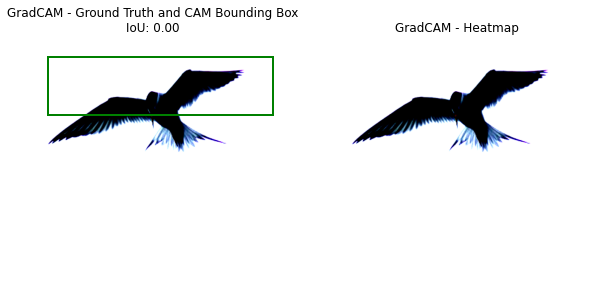

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


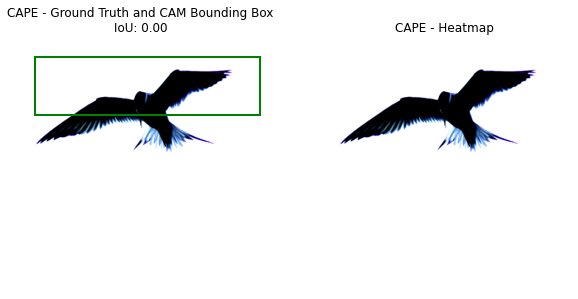

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


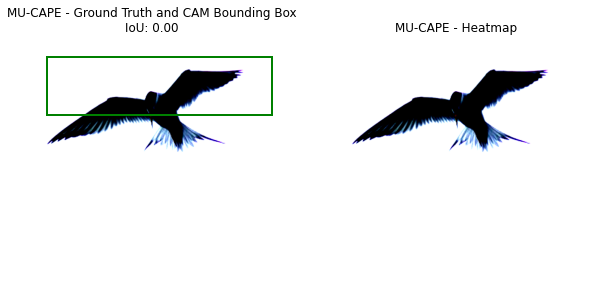

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


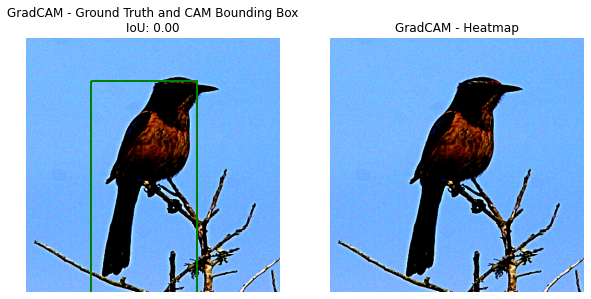

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


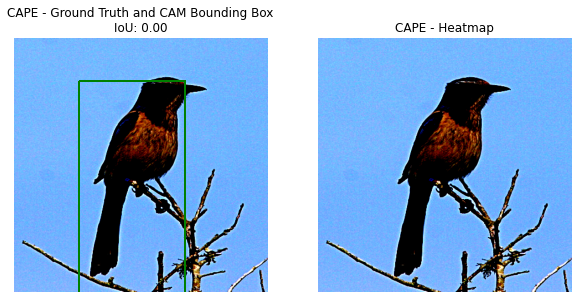

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


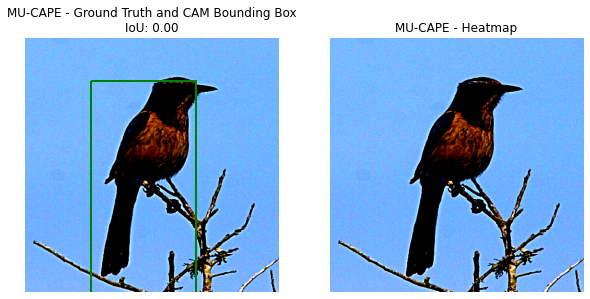

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


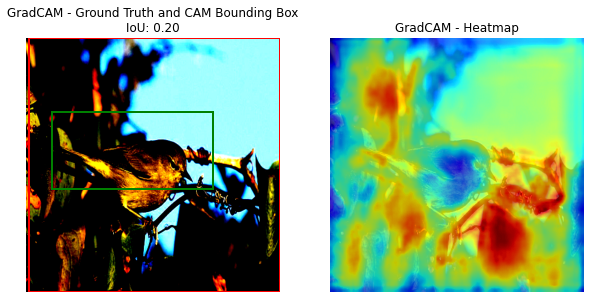

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


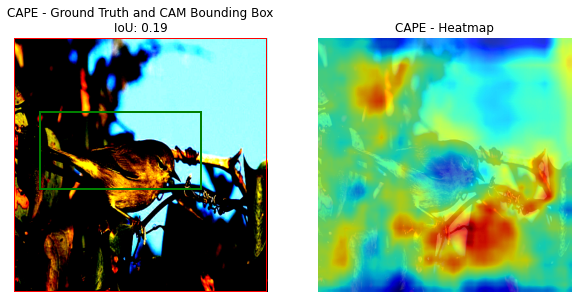

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


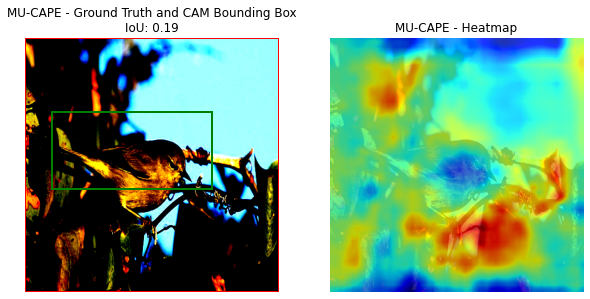

+---+---------+---------------------+
|   | Method  |         IoU         |
+---+---------+---------------------+
| 0 | GradCAM | 0.06528521840325849 |
| 1 |  CAPE   | 0.06455821151680795 |
| 2 | MU-CAPE | 0.06455821151680795 |
+---+---------+---------------------+


In [23]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tabulate import tabulate
import torch.nn.functional as F
# Dataset class
class CUB200Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = pd.read_csv(os.path.join(root_dir, 'images.txt'), sep=' ', names=['id', 'filepath'])
        self.labels = pd.read_csv(os.path.join(root_dir, 'image_class_labels.txt'), sep=' ', names=['id', 'label'])
        self.bboxes = pd.read_csv(os.path.join(root_dir, 'bounding_boxes.txt'), sep=' ', names=['id', 'x', 'y', 'width', 'height'])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, 'images', self.images.iloc[idx]['filepath'])
        image = Image.open(img_path).convert('RGB')
        bbox = self.bboxes.iloc[idx][['x', 'y', 'width', 'height']].values
        bbox = torch.tensor(bbox, dtype=torch.float32)
        label = self.labels.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label, bbox

# Image transformation
def cub_transform(image_size=448):
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return train_transform

train_transform = cub_transform()
train_dataset = CUB200Dataset(root_dir='CUB_200_2011/CUB_200_2011', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.load_state_dict(torch.load('cub_pytorch_resnet50.pth', map_location=device))
model = model.to(device)
model.eval()

# GradCAM class
import torch.nn.functional as F
import cv2
import numpy as np

class GradCAM:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.gradients = {}
        self.feature_maps = {}
        self.model.eval()
        self.register_hooks()

    # Hook to save the gradients for backward pass
    def save_gradient(self, layer_name):
        def hook(module, grad_input, grad_output):
            self.gradients[layer_name] = grad_output[0]
        return hook

    # Hook to save the feature maps during forward pass
    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output
        return hook

    # Register the hooks on the desired layers
    def register_hooks(self):
        for layer_name in self.layers:
            layer = dict([*self.model.named_modules()])[layer_name]
            layer.register_forward_hook(self.forward_hook(layer_name))
            layer.register_full_backward_hook(self.save_gradient(layer_name))

    # Standard GradCAM method
    def generate_gradcam(self, input_image, target_class=None):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = model_output.argmax(dim=1)
        
        class_loss = model_output[:, target_class]
        self.model.zero_grad()
        class_loss.backward()

        cams = []
        for layer_name in self.layers:
            gradients = self.gradients[layer_name]
            feature_maps = self.feature_maps[layer_name]
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
            for i in range(pooled_gradients.size(0)):
                feature_maps[0][i, :, :] *= pooled_gradients[i]
            cam = torch.sum(feature_maps[0], dim=0)
            cam = torch.relu(cam)

            # Normalize the CAM
            cam = cam - cam.min()
            cam = cam / cam.max()

            cam = cv2.resize(cam.detach().cpu().numpy(), (input_image.shape[2], input_image.shape[3]))  # Resize to input image size
            cams.append(cam)

        # Combine CAMs from all layers
        combined_cam = np.mean(cams, axis=0)
        return combined_cam

    # CAPE: Class Activation Probability Estimation
    def generate_cape(self, input_image, target_class=None):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = model_output.argmax(dim=1)

        class_loss = model_output[:, target_class]
        self.model.zero_grad()
        class_loss.backward()

        cams = []
        for layer_name in self.layers:
            gradients = self.gradients[layer_name]
            feature_maps = self.feature_maps[layer_name]
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
            for i in range(pooled_gradients.size(0)):
                feature_maps[0][i, :, :] *= pooled_gradients[i]
            cam = torch.sum(feature_maps[0], dim=0)
            cam = torch.relu(cam)

            # Normalize the CAM and apply softmax for CAPE
            cam = cam - cam.min()
            cam = cam / cam.max()

            # Apply softmax to convert the heatmap into a probability map
            cam_prob = F.softmax(cam, dim=0)
            cam_prob = cv2.resize(cam_prob.detach().cpu().numpy(), (input_image.shape[2], input_image.shape[3]))  # Resize to input image size
            cams.append(cam_prob)

        # Combine probabilistic CAMs from all layers
        combined_cape = np.mean(cams, axis=0)
        return combined_cape

    # MU-CAPE: Multi-Unit Class Activation Probability Estimation
    def generate_mu_cape(self, input_image, target_class=None):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = model_output.argmax(dim=1)

        class_loss = model_output[:, target_class]
        self.model.zero_grad()
        class_loss.backward()

        layer_cape_probs = []
        for layer_name in self.layers:
            gradients = self.gradients[layer_name]
            feature_maps = self.feature_maps[layer_name]
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
            for i in range(pooled_gradients.size(0)):
                feature_maps[0][i, :, :] *= pooled_gradients[i]
            cam = torch.sum(feature_maps[0], dim=0)
            cam = torch.relu(cam)

            # Normalize the CAM and apply softmax for CAPE
            cam = cam - cam.min()
            cam = cam / cam.max()
            cam_prob = F.softmax(cam, dim=0)

            # Resize to input image size
            cam_prob = cv2.resize(cam_prob.detach().cpu().numpy(), (input_image.shape[2], input_image.shape[3]))
            layer_cape_probs.append(cam_prob)

        # MU-CAPE: Combine the probabilistic outputs from multiple layers
        combined_mu_cape = np.mean(layer_cape_probs, axis=0)
        return combined_mu_cape



# Utility functions for IoU, visualization, and table display
def extract_high_intensity_region(heatmap, threshold=0.7):
    _, thresholded = cv2.threshold(heatmap, threshold * heatmap.max(), 255, cv2.THRESH_BINARY)
    thresholded = np.uint8(thresholded)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        return cv2.boundingRect(largest_contour)
    return 0, 0, 0, 0

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou



def visualize_cam(image, gt_bbox, cam_bbox, heatmap, iou, method_name):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2], gt_bbox[3], fill=False, edgecolor='green', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((cam_bbox[0], cam_bbox[1]), cam_bbox[2], cam_bbox[3], fill=False, edgecolor='red', linewidth=2))
    plt.title(f'{method_name} - Ground Truth and CAM Bounding Box\nIoU: {iou:.2f}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.8)
    plt.title(f'{method_name} - Heatmap')
    plt.axis('off')
    plt.show()

def main():
    layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
    threshold = 0.3

    # Initialize lists to store IoU values for GradCAM, CAPE, and MU-CAPE
    iou_gradcam_list = []
    iou_cape_list = []
    iou_mu_cape_list = []

    count = 0
    for images, labels, bboxes in train_loader:
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
        target_class = labels[0].item()
        gt_bbox = bboxes[0].cpu().numpy()

        # GradCAM
        grad_cam = GradCAM(model, layer_names)
        cam = grad_cam.generate_gradcam(images, target_class)
        cam_bbox = extract_high_intensity_region(cam, threshold=0.5)
        iou_gradcam = calculate_iou(gt_bbox, cam_bbox)
        iou_gradcam_list.append(iou_gradcam)
        visualize_cam(images[0].cpu().permute(1, 2, 0).numpy(), gt_bbox, cam_bbox, cam, iou_gradcam, 'GradCAM')

        # CAPE
        cape = grad_cam.generate_cape(images, target_class)
        cape_bbox = extract_high_intensity_region(cape, threshold=0.5)
        iou_cape = calculate_iou(gt_bbox, cape_bbox)
        iou_cape_list.append(iou_cape)
        visualize_cam(images[0].cpu().permute(1, 2, 0).numpy(), gt_bbox, cape_bbox, cape, iou_cape, 'CAPE')

        # MU-CAPE
        mu_cape = grad_cam.generate_mu_cape(images, target_class)
        mu_cape_bbox = extract_high_intensity_region(mu_cape, threshold=0.5)
        iou_mu_cape = calculate_iou(gt_bbox, mu_cape_bbox)
        iou_mu_cape_list.append(iou_mu_cape)
        visualize_cam(images[0].cpu().permute(1, 2, 0).numpy(), gt_bbox, mu_cape_bbox, mu_cape, iou_mu_cape, 'MU-CAPE')

        count += 1
        if count == 3:  # Limit the number of iterations for demonstration
            break

    # Display IoU results
    display_iou_results(np.mean(iou_gradcam_list), np.mean(iou_cape_list), np.mean(iou_mu_cape_list))

# Function to display the IoU results for all methods
def display_iou_results(iou_gradcam, iou_cape, iou_mu_cape):
    data = {
        'Method': ['GradCAM', 'CAPE', 'MU-CAPE'],
        'IoU': [iou_gradcam, iou_cape, iou_mu_cape]
    }
    iou_results_df = pd.DataFrame(data)
    table = tabulate(iou_results_df, headers='keys', tablefmt='pretty')
    print(table)

# Run the main loop
if __name__ == "__main__":
    main()
